In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.abspath(''))
import numpy as np
import pandas as pd
import geopandas as gpd
from geo import COM, PROV, REG, DEMOG

import matplotlib.pyplot as plt
%matplotlib notebook

def datech(s):
    return f'{s[6:]}-{s[4:6]}-{s[0:4]}'

In [2]:
CWD = Path(os.path.abspath(''))

data_dir = CWD / 'protezione_civile/COVID-19'
prov_dir = data_dir /  'dati-province'

In [3]:
DEMOG[['prov_name', 'population']].groupby('prov_name').sum().query('prov_name=="roma"')
DEMOG.query('prov_name=="roma" and Sesso=="totale"')
pop = DEMOG.pivot_table(index=['prov_name'], columns=['Sesso', 'Stato civile', 'Età'])['population']['totale']['totale'][['totale']].reset_index()
prov = PROV.merge(pop, on='prov_name')
#prov.plot('totale', legend=True)
#plt.title('Residenti al primo Gennaio 2020')

# Dati della Protezione Civile
Data from [github.com/pcm-dpc/COVID-19](https://github.com/pcm-dpc/COVID-19).

Questi dati sono da aggiornare giornalmente coi comandi:
```
cd covid-19/protezione_civile/COVID-19
git fetch
git merge
```

In [4]:
df = []
prec = lambda s: f'{s:.4f}'
for f in sorted(prov_dir.glob('dpc-covid19-ita-province-2020*.csv')):
    tmp_df = pd.read_csv(f, encoding='latin-1')
    tmp_df['day'] = str(f).split('/')[-1].split('-')[-1].rstrip('.csv')
    tmp_df['geometry'] = gpd.points_from_xy(tmp_df['long'], tmp_df['lat'])
    tmp_df['lat_long'] = tmp_df['lat'].apply(prec).astype(str) + '_' + tmp_df['long'].apply(prec).astype(str)
    df.append(tmp_df)
    del tmp_df
DF = pd.concat(df)

df = DF.pivot_table(index='sigla_provincia', columns='day', values='totale_casi')
dates = [_ for _ in df.columns if '20' in _]
df['totale_casi'] = df.sum(1)
df['nuovi_casi'] = df[dates[-1]] - df[dates[-2]]

In [5]:
m = prov.merge(df, left_on='prov_acr', right_on='sigla_provincia')
tocsv = pd.DataFrame(m.drop(columns=['geometry', 'prov_istat_code_num', 'reg_istat_code', 'reg_istat_code_num', 'prov_istat_code']))
m['casi_100k'] = m['totale_casi'] / m['totale'] * 100000
m['nuovi_casi_100k'] = m['nuovi_casi'] / m['totale'] * 100000
m['var_perc_1day'] = 100 * (m[dates[-1]] - m[dates[-2]]) / m[dates[-2]]

In [6]:
tocsv.rename(mapper={'totale': 'residenti'}, axis=1).to_csv('csv/andamento_province.csv', index=False)

<IPython.core.display.Javascript object>


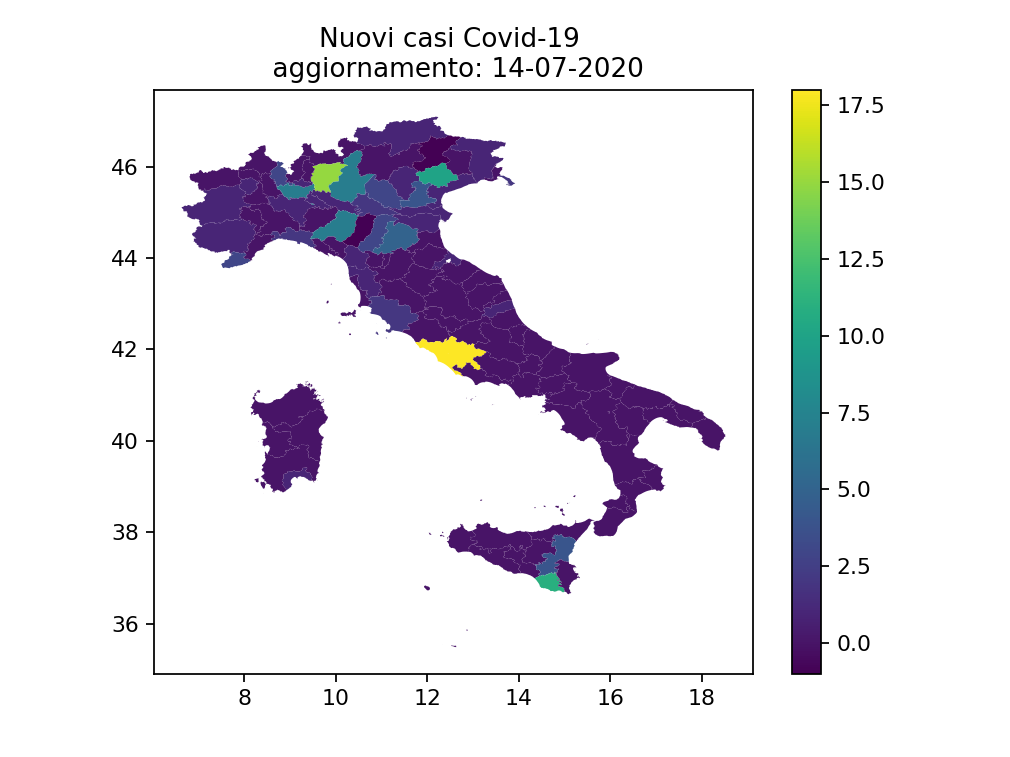

<IPython.core.display.Javascript object>


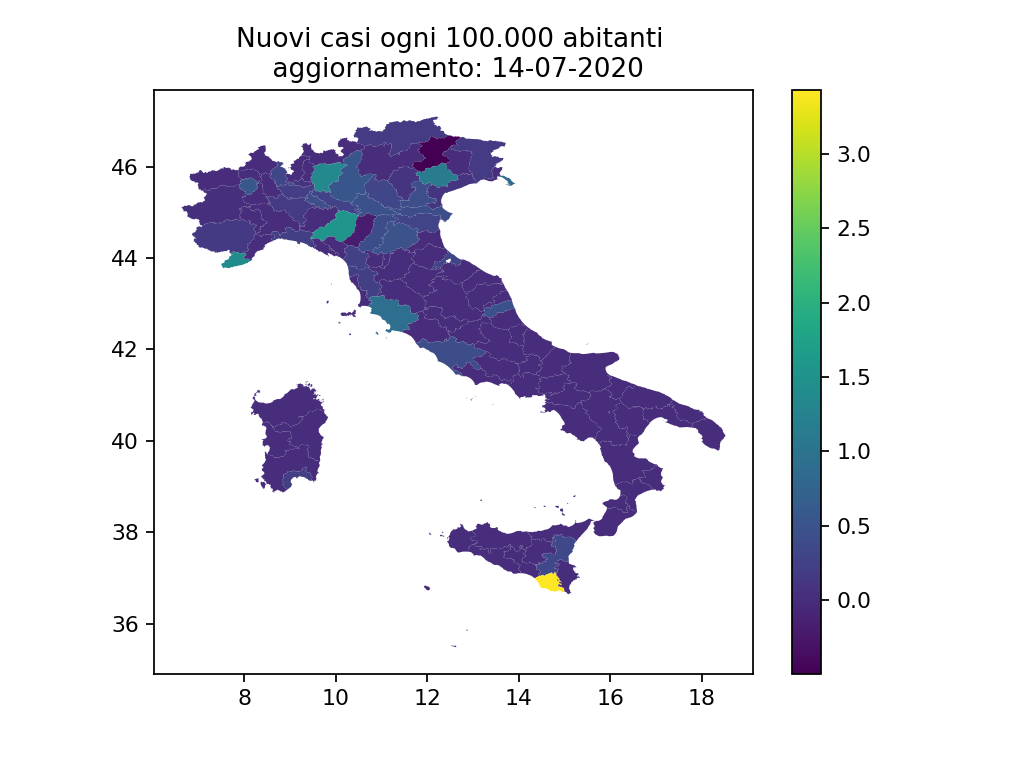

<IPython.core.display.Javascript object>


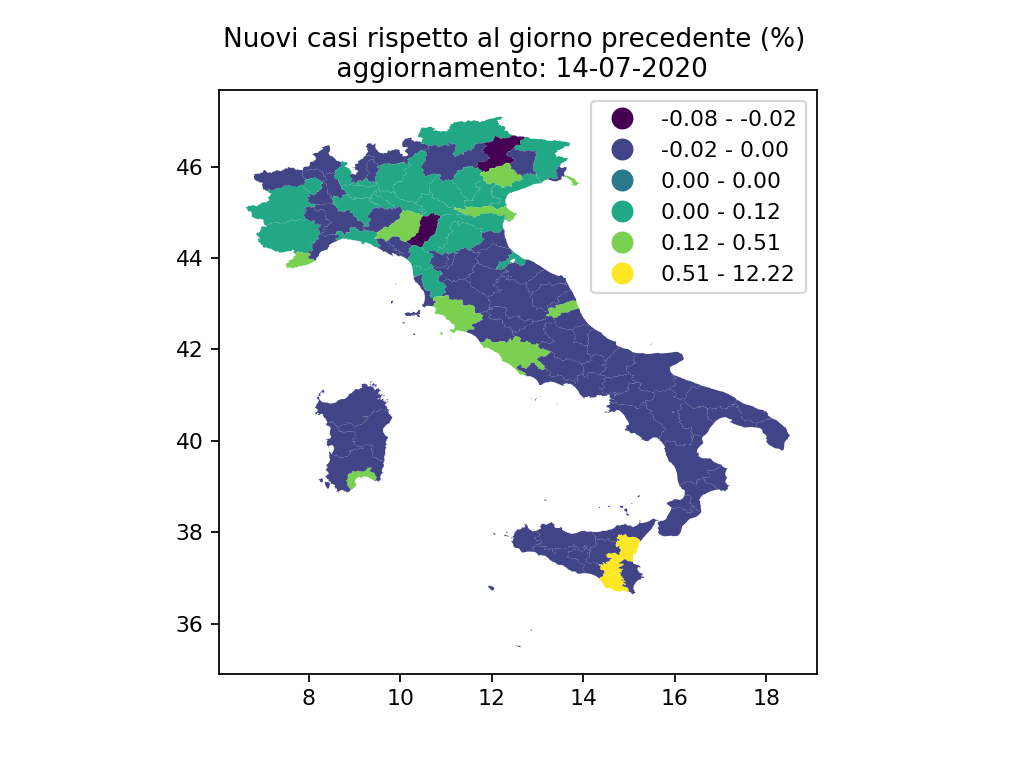

Text(0.5, 1.0, 'Nuovi casi rispetto al giorno precedente (%) \n aggiornamento: 14-07-2020')

In [7]:
date_ddmmyyyy = datech(dates[-1])
m.plot(column='nuovi_casi', legend=True)
plt.title(f'Nuovi casi Covid-19 \n aggiornamento: {date_ddmmyyyy}')

m.plot(column='nuovi_casi_100k', legend=True)
plt.title(f'Nuovi casi ogni 100.000 abitanti \n aggiornamento: {date_ddmmyyyy}')

#m.plot(column='var_perc_1day', legend=True, scheme='user_defined', classification_kwds={'bins':[25, 50, 75, 100]})
m.plot(column='var_perc_1day', legend=True, scheme='percentiles')
plt.title(f'Nuovi casi rispetto al giorno precedente (%) \n aggiornamento: {date_ddmmyyyy}')

#m.plot(column='casi_100k', legend=True)
#plt.title(f'Casi totali ogni 100.000 abitanti \n aggiornamento: {df.columns[-3]}')

# Andamento per Regioni

In [8]:
df = DF.pivot_table(index='denominazione_regione', columns='data', values='totale_casi', aggfunc=np.sum)
df['incremento'] = df[df.columns[-1]] - df[df.columns[-2]]
df = df.sort_values(['incremento', df.columns[-1]], ascending=[0, 0])
display(df[df.columns[-3:]])

data,2020-07-13T17:00:00,2020-07-14T17:00:00,incremento
denominazione_regione,,,
Lombardia,95143,95173,30
Veneto,19401,19420,19
Lazio,8338,8356,18
Sicilia,3100,3115,15
Emilia-Romagna,28958,28971,13
Liguria,10032,10038,6
Toscana,10326,10330,4
Friuli Venezia Giulia,3335,3338,3
Piemonte,31504,31507,3


# Andamento per Province

In [9]:
df = DF.pivot_table(index=['sigla_provincia', 'denominazione_provincia'], columns='data', values='totale_casi', aggfunc=np.sum)
df['incremento'] = (df.iloc[:, -1] - df.iloc[:, -2])
df = df.sort_values(['incremento', df.columns[-2]], ascending=[0, 0]).reset_index()
df.index.rename('rank', inplace=True)
df.columns.rename('', inplace=True)
BRi = df.query('sigla_provincia=="BR"').index.values[0]
display(df.iloc[[0,1,2,3,4,5,6,7,8,9,10,11,12,BRi,-3,-2,-1], [1,-2,-1]])

,denominazione_provincia,2020-07-14T17:00:00,incremento
rank,,,
0,Roma,6085,18
1,Bergamo,14750,15
2,Ragusa,101,11
3,Treviso,2707,10
4,Milano,24626,7
5,Brescia,15796,7
6,Parma,3718,7
7,Bologna,5402,5
8,Padova,3991,4


<IPython.core.display.Javascript object>


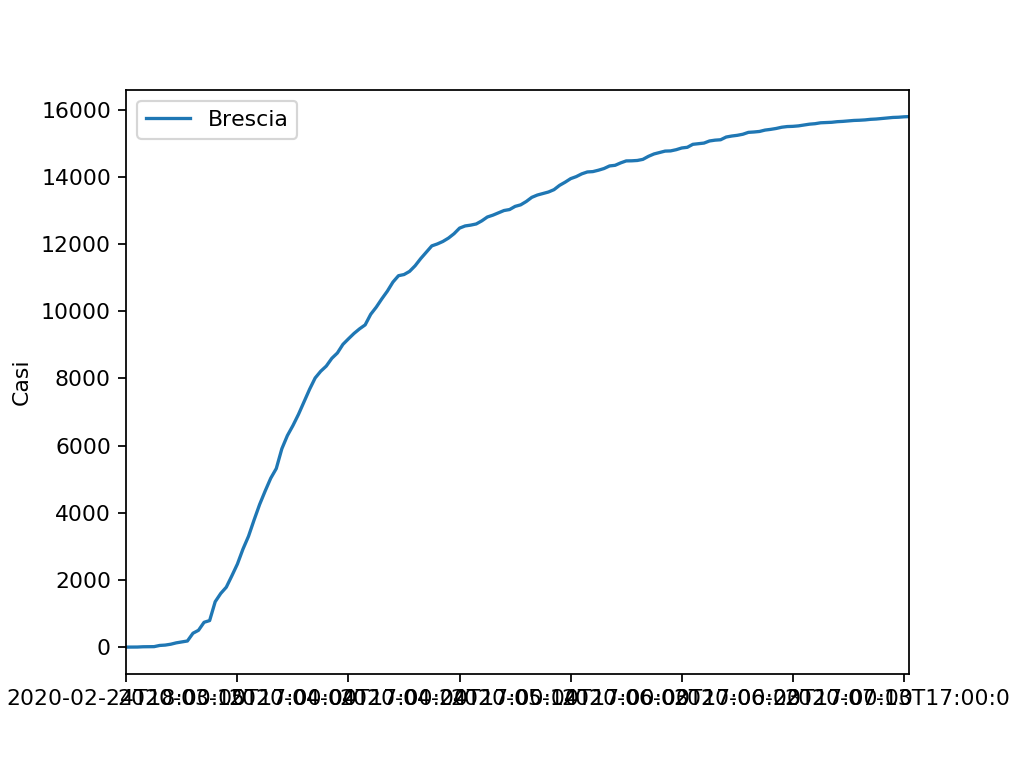

,sigla_provincia,denominazione_provincia,2020-02-24T18:00:00,2020-02-25T18:00:00,2020-02-26T18:00:00,2020-02-27T18:00:00,2020-02-28T18:00:00,2020-02-29T17:00:00,2020-03-01T17:00:00,2020-03-02T17:00:00,...,2020-07-06T17:00:00,2020-07-07T17:00:00,2020-07-08T17:00:00,2020-07-09T17:00:00,2020-07-10T17:00:00,2020-07-11T17:00:00,2020-07-12T17:00:00,2020-07-13T17:00:00,2020-07-14T17:00:00,incremento
rank,,,,,,,,,,,,,,,,,,,,,
5,BS,Brescia,0,0,2,10,13,14,49,60,...,15697,15714,15723,15737,15754,15770,15776,15789,15796,7


In [10]:
df[df['denominazione_provincia']=='Brescia'].T.iloc[2:-1].plot()
plt.legend(['Brescia'])
plt.ylabel('Casi')
display(df[df['denominazione_provincia']=='Brescia'])

# Regioni

In [11]:
reg_dir = data_dir /  'dati-regioni'
df = []
prec = lambda s: f'{s:.4f}'
for f in sorted(reg_dir.glob('dpc-covid19-ita-regioni-2020*.csv')):
    tmp_df = pd.read_csv(f, encoding='latin-1')
    df.append(tmp_df)
    del tmp_df
DF = pd.concat(df)

In [12]:
morti = DF.pivot_table(index='denominazione_regione', columns='data', values='deceduti').sum().to_numpy()
np.diff(morti)

array([  3,   2,   5,   4,   8,   5,  18,  27,  28,  41,  49,  36, 133,
        97, 168, 196, 189, 250, 175, 368, 349, 345, 475, 427, 627, 793,
       651, 601, 743, 683, 662, 969, 889, 756, 812, 837, 727, 760, 766,
       681, 525, 636, 604, 542, 610, 570, 619, 431, 566, 602, 578, 525,
       575, 482, 433, 454, 534, 437, 464, 420, 415, 260, 333, 382, 323,
       285, 269, 474, 174, 195, 236, 369, 274, 243, 194, 165, 179, 172,
       195, 262, 242, 153, 145,  99, 162, 161, 156, 130, 119,  50,  92,
        78, 117,  70,  87, 111,  75,  60,  55,  71,  88,  85,  72,  53,
        65,  79,  71,  53,  56,  78,  44,  26,  34,  43,  66,  47,  49,
        24,  23,  18, -31,  34,  30,   8,  22,   6,  23,  21,  30,  15,
        21,   7,   8,  30,  15,  12,  12,   7,   9,  13,  17])

In [13]:
casi = DF.pivot_table(index='denominazione_regione', columns='data', values='totale_casi').sum()
np.diff(casi)

array([  93,   78,  250,  238,  240,  566,  342,  466,  587,  769,  778,
       1247, 1492, 1797,  977, 2313, 2651, 2547, 3497, 3590, 3233, 3526,
       4207, 5322, 5986, 6557, 5560, 4789, 5249, 5210, 6153, 5959, 5974,
       5217, 4050, 4053, 4782, 4668, 4585, 4805, 4316, 3599, 3039, 3836,
       4204, 3951, 4694, 4092, 3153, 2972, 2667, 3786, 3493, 3491, 3047,
       2256, 2729, 3370, 2646, 3021, 2357, 2324, 1739, 2091, 2086, 1872,
       1965, 1900, 1389, 1221, 1075, 1444, 1401, 1327, 1083,  802,  744,
       1402,  888,  992,  789,  875,  675,  451,  813,  665,  642,  652,
        669,  531,  300,  397,  584,  593,  516,  416,  355,  178,  318,
        321,  177,  518,  270,  197,  280,  283,  202,  379,  163,  346,
        338,  301,  210,  328,  331, -148,  264,  224,  221,  113,  577,
        296,  255,  175,  174,  126,  142,  182,  201,  223,  235,  192,
        208,  137,  193,  214,  276,  188,  234,  169,  114])

<IPython.core.display.Javascript object>


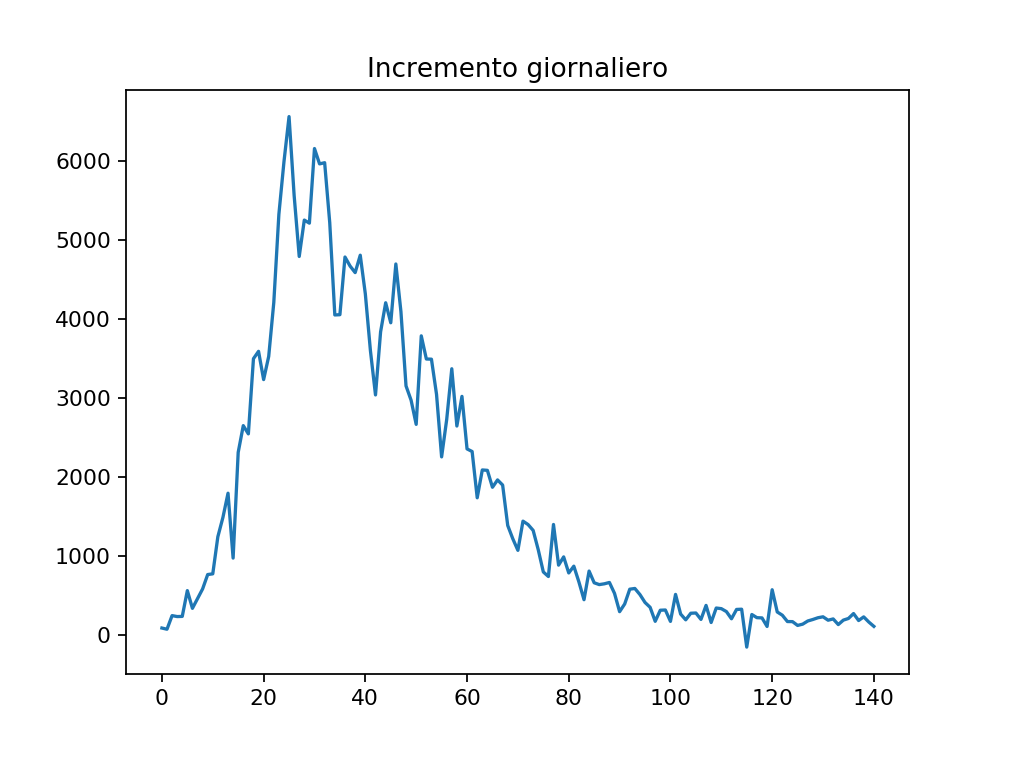

Text(0.5, 1.0, 'Incremento giornaliero')

In [14]:
plt.figure()
plt.plot(np.diff(casi))
plt.title('Incremento giornaliero')

# Dati Johns Hopkins
Data from [github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

/user/lantelmi/home/Software/Python3/miniconda3/envs/torch-1.4/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


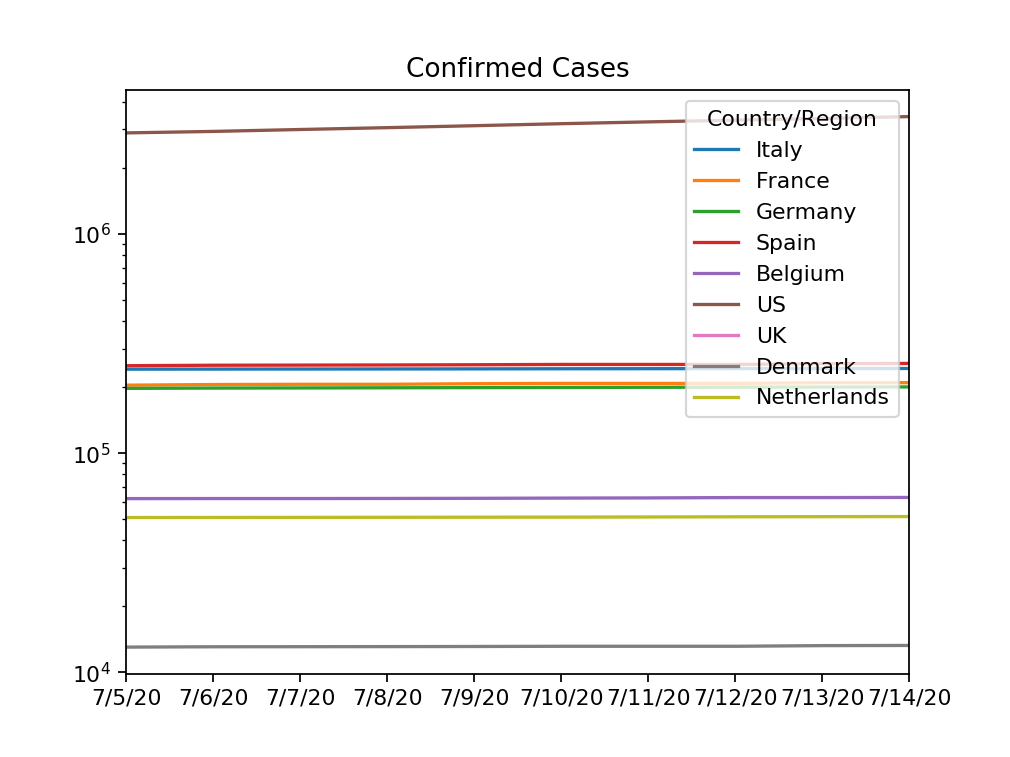

In [16]:
countries = ['Italy','France','Germany','Spain','Belgium', 'US', 'UK', 'Denmark', 'Netherlands']
jhdates = [c for c in df.columns if '/20' in c]
df.groupby('Country/Region').sum().loc[countries][jhdates[-10:]].T.plot(logy=True, title='Confirmed Cases')

# Andamento Globale

In [17]:
df = df.groupby('Country/Region').sum().loc[countries][jhdates[-10:]]
df['increment'] = df.iloc[:, -1] - df.iloc[:, -2]
df = df.sort_values(['increment', df.columns[-1]], ascending=[0, 0])
display(df)

/user/lantelmi/home/Software/Python3/miniconda3/envs/torch-1.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,7/5/20,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,increment
Country/Region,,,,,,,,,,,
US,2891124.0,2936077.0,2996098.0,3054699.0,3117946.0,3184573.0,3245925.0,3304942.0,3364157.0,3431574.0,67417.0
Spain,250545.0,251789.0,252130.0,252513.0,253056.0,253908.0,253908.0,253908.0,255953.0,256619.0,666.0
Germany,197523.0,198064.0,198343.0,198699.0,199001.0,199332.0,199709.0,199919.0,200180.0,200456.0,276.0
Italy,241611.0,241819.0,241956.0,242149.0,242363.0,242639.0,242827.0,243061.0,243230.0,243344.0,114.0
Belgium,62016.0,62058.0,62058.0,62123.0,62210.0,62357.0,62469.0,62707.0,62707.0,62781.0,74.0
Netherlands,50834.0,50870.0,50907.0,50959.0,51013.0,51055.0,51136.0,51237.0,51308.0,51362.0,54.0
Denmark,13033.0,13079.0,13089.0,13101.0,13117.0,13147.0,13147.0,13147.0,13238.0,13262.0,24.0
France,204222.0,205597.0,206072.0,206072.0,207356.0,208015.0,208015.0,208015.0,209640.0,209640.0,0.0
UK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# France

In [18]:
FR = pd.read_csv('https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv')

In [19]:
idx = ['DEP' in _ for _ in FR['maille_code']]
DEP = FR.loc[idx].pivot_table(index=['maille_code', 'maille_nom'], columns=['date'], values=['cas_confirmes']).droplevel(level=0, axis=1)
DEP.sum(1).sort_values(ascending=False).to_frame().iloc[:25]

,,0
maille_code,maille_nom,
DEP-68,Haut-Rhin,4106.000000
DEP-56,Morbihan,3405.000000
DEP-69,Rhône,3222.000000
DEP-13,Bouches-du-Rhône,3038.000000
DEP-74,Haute-Savoie,2830.333333
DEP-42,Loire,2009.000000
DEP-2A,Corse-du-Sud,1976.000000
DEP-44,Loire-Atlantique,1912.500000
DEP-67,Bas-Rhin,1876.000000
